#  Goal

The goal of this project is to create a predicitve model which will identify person of interest or POI from the email data. In order to idetify POI, we use the emails exchanged between the employees of Enron and we extract various metrics from it. This can be used in conjuction with a machine learning model to identify an employee who is potentially performing fraudulent activities.


# Data Exploration

The following questions are answered by data exploration:

   - total number of data points
   - allocation across classes (POI/non-POI)
   - number of features used
   - are there features with many missing values?


In [18]:
from IPython.core.display import HTML
from time import time
import sys
import pickle
import pprint as pp
import numpy as np
sys.path.append("../tools/")
from parameters import add_features
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import ListedColormap
%matplotlib inline
matplotlib.style.use('ggplot')
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi','salary','bonus','to_messages','deferral_payments',\
                 'total_payments','exercised_stock_options','restricted_stock',\
                 'shared_receipt_with_poi','restricted_stock_deferred',\
                 'total_stock_value','expenses','loan_advances','from_messages',\
                 'other','from_this_person_to_poi','director_fees','deferred_income',\
                 'long_term_incentive','email_address','from_poi_to_this_person']
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
def find_POI(data_dict):
    datapoints=0
    poi=0
    non_poi=0
    for key,value in data_dict.iteritems():
        datapoints +=1
        if value["poi"] == 1:
            poi+=1
        else:
            non_poi+=1
    print "\nTotal number of data points\t:",datapoints
    print "Total number of poi\t\t:",poi,"\nTotal number of non-poi\t\t:",non_poi
    print "No of features in original dataset:",len(features_list)
find_POI(data_dict)


Total number of data points	: 146
Total number of poi		: 18 
Total number of non-poi		: 128
No of features in original dataset: 21


Since there are very few POIs(18) compared to Non-POIs (128) in the dataset, this can lead to lowered performance of the model. 

In [19]:
def POI_split(data_dict,features_list):
    NAs = {}
    POIs = {}
    nonPOIs = {}
    for f in features_list:
        NAs[f] = 0
        POIs[f] = 0
        nonPOIs[f] = 0
    
    for key,value in data_dict.iteritems():
        for f in features_list:
            if value[f]=="NaN":
                NAs[f]+=1
            if value[f] != "NaN" and value["poi"] ==1:
                POIs[f] +=1
            if value[f] != "NaN" and value["poi"] ==0:
                nonPOIs[f] +=1

    print "No. of NaN in each category"
    pp.pprint (NAs)
    print "No. of POIs in each category"
    pp.pprint (POIs)
    print "No. of nonPOIs in each category"
    pp.pprint (nonPOIs)

POI_split(data_dict,features_list)

No. of NaN in each category
{'bonus': 64,
 'deferral_payments': 107,
 'deferred_income': 97,
 'director_fees': 129,
 'email_address': 35,
 'exercised_stock_options': 44,
 'expenses': 51,
 'from_messages': 60,
 'from_poi_to_this_person': 60,
 'from_this_person_to_poi': 60,
 'loan_advances': 142,
 'long_term_incentive': 80,
 'other': 53,
 'poi': 0,
 'restricted_stock': 36,
 'restricted_stock_deferred': 128,
 'salary': 51,
 'shared_receipt_with_poi': 60,
 'to_messages': 60,
 'total_payments': 21,
 'total_stock_value': 20}
No. of POIs in each category
{'bonus': 16,
 'deferral_payments': 5,
 'deferred_income': 11,
 'director_fees': 0,
 'email_address': 18,
 'exercised_stock_options': 12,
 'expenses': 18,
 'from_messages': 14,
 'from_poi_to_this_person': 14,
 'from_this_person_to_poi': 14,
 'loan_advances': 1,
 'long_term_incentive': 12,
 'other': 18,
 'poi': 18,
 'restricted_stock': 17,
 'restricted_stock_deferred': 0,
 'salary': 17,
 'shared_receipt_with_poi': 14,
 'to_messages': 14,
 'tot

## Outlier Investigation

Two outliers are identified for the keys **"TOTAL", "LOCKHART EUGENE E",** ` and ` **"THE TRAVEL AGENCY IN THE PARK"**. These outliers are handled in the original code in preprocessing.

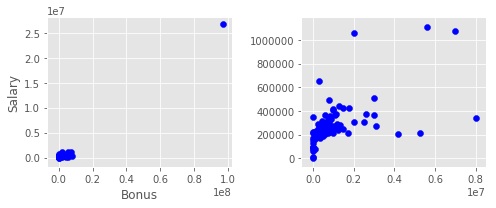

In [20]:
def remove_outliers(data_dict):
    plt.figure(figsize=(7, 3))
    temp_data = featureFormat(data_dict, ["salary","bonus"], sort_keys = True)
    ax=plt.subplot(1,2,1)
    for point in temp_data:
        bonus=point[0]
        salary = point[1]
        ax.scatter(salary, bonus, color="blue" )
    plt.xlabel("Bonus")
    plt.ylabel("Salary")
    ax=plt.subplot(1,2,2)

    # Removing outliers from the original dataset
    for key in ["TOTAL","LOCKHART EUGENE E", "THE TRAVEL AGENCY IN THE PARK"]:
        data_dict.pop(key)


    temp_data = featureFormat(data_dict, ["salary","bonus"], sort_keys = True)
    for point in temp_data:
        bonus=point[0]
        salary = point[1]
        ax.scatter( salary, bonus, color="blue" )
    ax=plt.subplot(1,2,2)
    plt.tight_layout()
    plt.show()

    for key,value in data_dict.iteritems():
        if key in ["TOTAL","LOCKHART EUGENE E", "THE TRAVEL AGENCY IN THE PARK"]:
            print key,value
    return data_dict

new_data_dict = remove_outliers(data_dict)

## Adding new features to Data

Each column form data is explored through histograms for normality. We identified these parameters to be determinal in identifying "POI" since majority of POI share non-zero value for this field. A log or sqrt transformed value seems to be more appropriate as it is distributed more normally. Numerical value of 1.0 is added before log transformation to avoid `-Inf` value while taking `log`.

As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. 

* New features are engineered from the existing ones. We chose the below mentioned features as it gives a more normally distributed data. Feature importances for each features is given below based on the feature selection employed such as `SelecKBest`, `RFE` etc.

* We chose `Expenses` for POIs since it could be higher as the POIs tend to be profligate.

    *   log(1+bonus)
    *   log(1+salary)
    *   log(1+other)
    *   sqrt(expenses)
    *   log(1+total_payments)


In [17]:
import pandas as pd
import matplotlib.style
from parameters import add_features
matplotlib.style.use('ggplot')
new_features_list,new_data_dict = add_features(features_list, data_dict)
data_pd = pd.DataFrame.from_dict(new_data_dict, orient='index', dtype=float)
data_pd.head()#[['salary_log','expenses_sqrt','bonus_log','salary_log','other_log']]

,to_messages,deferral_payments,bonus_log,expenses,poi,deferred_income,email_address,long_term_incentive,salary_log,restricted_stock_deferred,...,expenses_sqrt,total_stock_value,from_poi_to_this_person,other_log,from_this_person_to_poi,total_payments_log,restricted_stock,salary,total_payments,exercised_stock_options
ALLEN PHILLIP K,2902.0,2869717.0,15.244625,13868.0,0.0,-3081055.0,phillip.allen@enron.com,304805.0,12.215810,-126027.0,...,117.766719,1729541.0,47.0,5.030438,65.0,15.316125,126027.0,201955.0,4484442.0,1729541.0
BADUM JAMES P,NaN,178980.0,NaN,3486.0,0.0,NaN,NaN,NaN,NaN,NaN,...,59.050826,257817.0,NaN,NaN,NaN,12.114330,NaN,NaN,182466.0,257817.0
BANNANTINE JAMES M,566.0,NaN,NaN,56301.0,0.0,-5104.0,james.bannantine@enron.com,NaN,6.171701,-560222.0,...,237.280425,5243487.0,39.0,13.669934,0.0,13.727989,1757552.0,477.0,916197.0,4046157.0
BAXTER JOHN C,NaN,1295738.0,13.997833,11200.0,0.0,-1386055.0,NaN,1586055.0,12.495393,NaN,...,105.834777,10623258.0,NaN,14.793951,NaN,15.544391,3942714.0,267102.0,5634343.0,6680544.0
BAY FRANKLIN R,NaN,260455.0,12.899222,129142.0,0.0,-201641.0,frank.bay@enron.com,NaN,12.387031,-82782.0,...,359.364717,63014.0,NaN,4.248495,NaN,13.626404,145796.0,239671.0,827696.0,NaN


In [176]:
print "\nNo. of features after adding 5 new features :{0}\n\nNames of features\t:\n{1}"\
.format(len(data_pd.columns), list(data_pd.columns))
new_features = ['bonus_log','salary_log','other_log','expenses_sqrt',
                    'total_payments_log']


No. of features after adding 5 new features :26

Names of features	:
['to_messages', 'deferral_payments', 'bonus_log', 'expenses', 'poi', 'deferred_income', 'email_address', 'long_term_incentive', 'salary_log', 'restricted_stock_deferred', 'shared_receipt_with_poi', 'loan_advances', 'from_messages', 'other', 'director_fees', 'bonus', 'expenses_sqrt', 'total_stock_value', 'from_poi_to_this_person', 'other_log', 'from_this_person_to_poi', 'total_payments_log', 'restricted_stock', 'salary', 'total_payments', 'exercised_stock_options']


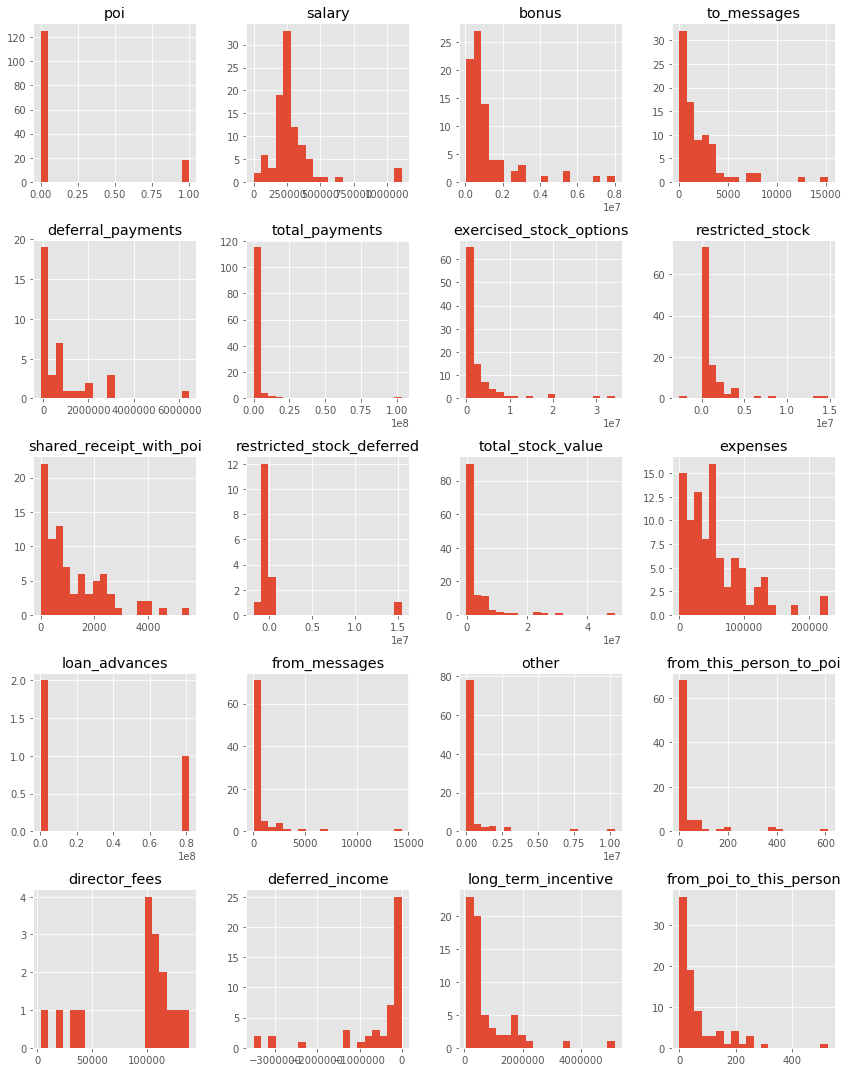

In [144]:
def plot_histgrams1():
    # plotting histograms of columns in data
    dat_cols = ['poi','salary','bonus','to_messages','deferral_payments',\
                     'total_payments','exercised_stock_options','restricted_stock',\
                     'shared_receipt_with_poi','restricted_stock_deferred',\
                     'total_stock_value','expenses','loan_advances','from_messages',\
                     'other','from_this_person_to_poi','director_fees','deferred_income',\
                     'long_term_incentive','from_poi_to_this_person']
    i=1
    fig=plt.figure(figsize=(12,15))
    for c in dat_cols:
        fig.add_subplot(5,4,i)
        data_pd[c].hist(bins=20)
        plt.title(c)
        i+=1
    plt.tight_layout()
    plt.show()

plot_histgrams1()

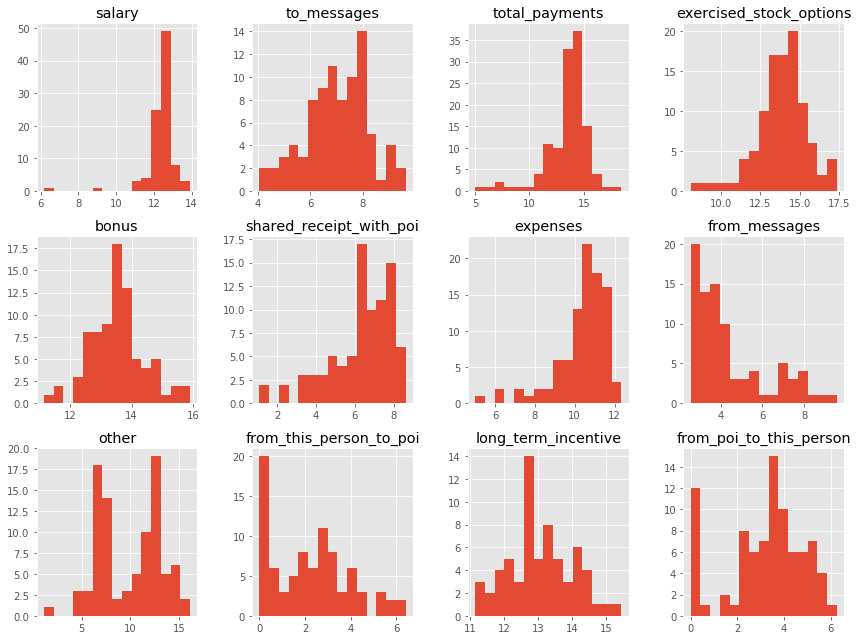

In [146]:
def plot_histgrams2():
    # log transformed histograms
    log_dat_cols = ['salary','to_messages','total_payments',\
                    'exercised_stock_options', 'bonus', 'shared_receipt_with_poi',\
                    'expenses', 'from_messages','other', 'from_this_person_to_poi',\
                   'long_term_incentive', 'from_poi_to_this_person']
    fig2=plt.figure(figsize=(12,9))
    i=1
    for c in log_dat_cols:
        fig2.add_subplot(3,4,i)
        np.log(1+data_pd[c]).hist(bins=15)
        plt.title(c)
        i +=1
    plt.tight_layout()
    plt.show()

plot_histgrams2()

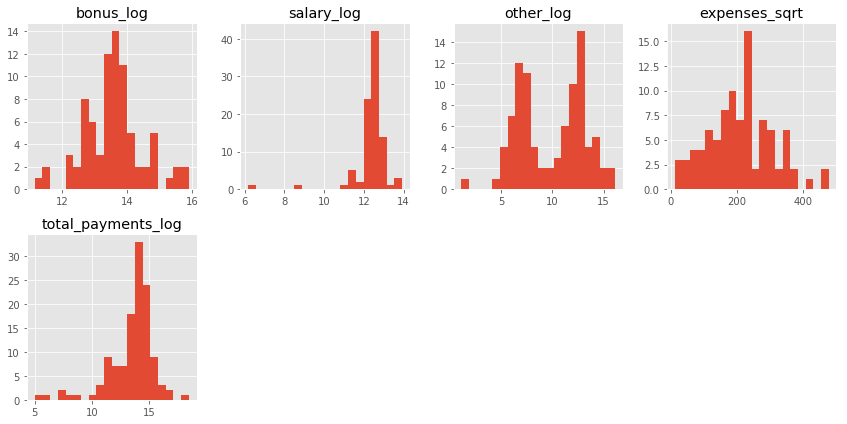

In [147]:
def plot_histgrams3(new_features):
    # histograms of additional features
    #,'poi_ratio','restricted_stock_ratio']
    i=1
    fig=plt.figure(figsize=(12,6))
    for c in new_features:
        fig.add_subplot(2,4,i)
        data_pd[c].hist(bins=20)
        plt.title(c)
        i+=1
    plt.tight_layout()
    plt.show()
plot_histgrams3(new_features)

# Feature Selection

Feature selection is also called variable selection or attribute selection.

It is the automatic selection of attributes in your data (such as columns in tabular data) that are most relevant to the predictive modeling problem you are working on.

Feature selection methods can be used to identify and remove unneeded, irrelevant and redundant attributes from data that do not contribute to the accuracy of a predictive model or may in fact decrease the accuracy of the model.

> We have tried different feature selection techniques and report their scores. The final choice of feature selector depends on algorithm used, since it is the combination which optimize the performance.

What features did you end up using in your POI identifier, and what selection process did you use to pick them?

* Various feature selectors were used in conjuction with the classifier to find the most suited combination.
* The actual number of the features selected is based on the scores computed by `GridsearchCV`.

Did you have to do any scaling? Why or why not? 
* Yes, feature scaling was used in the logistic regresion model. We did not find any tangible increase in the perfomance using features scaling in Naive Bayes and Decision Tree algorithms.



## Importing and cleaning

In [23]:
from time import time
import sys
import pickle
import numpy as np
sys.path.append("../tools/")
from parameters import add_features
from feature_format import featureFormat, targetFeatureSplit
from matplotlib import pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2
features_list = ['poi',
				'salary','bonus','to_messages',
				'deferral_payments','total_payments','exercised_stock_options',
				'restricted_stock','shared_receipt_with_poi',
				'restricted_stock_deferred','total_stock_value',
				'expenses','loan_advances','from_messages','other',
				'from_this_person_to_poi','director_fees',
				'deferred_income','long_term_incentive',
				'email_address','from_poi_to_this_person']
# Adding more features
new_features = ['bonus_log','salary_log','other_log','expenses_sqrt',
                'total_payments_log']
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

### Task 2: Remove outliers
[data_dict.pop(key) for key in ["TOTAL","LOCKHART EUGENE E", "THE TRAVEL AGENCY IN THE PARK"]]

### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.
all_features, my_dataset = add_features(features_list, data_dict)

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, all_features, sort_keys = True)
labels, features = targetFeatureSplit(data)

N_OBSERVATIONS, N_FEATURES = np.array(features).shape

In [24]:
def indexed_list(items):
    """
    Prints the index and items in list
    """
    index = 0
    while index < len(items):
        print index, items[index]
        index += 1
indexed_list(all_features[1:])

0 salary
1 bonus
2 to_messages
3 deferral_payments
4 total_payments
5 exercised_stock_options
6 restricted_stock
7 shared_receipt_with_poi
8 restricted_stock_deferred
9 total_stock_value
10 expenses
11 loan_advances
12 from_messages
13 other
14 from_this_person_to_poi
15 director_fees
16 deferred_income
17 long_term_incentive
18 email_address
19 from_poi_to_this_person
20 bonus_log
21 salary_log
22 other_log
23 expenses_sqrt
24 total_payments_log


## K-Best

Since K-Best is  a univariate feature selector, and gives you ranks of top features. We find top 8 (1/3rd of total) features and progressively scan using `GridseachCV` to find best feature set. The scoring function `f_classif` and `mutual_info_classif` is tested to find the k-score. 

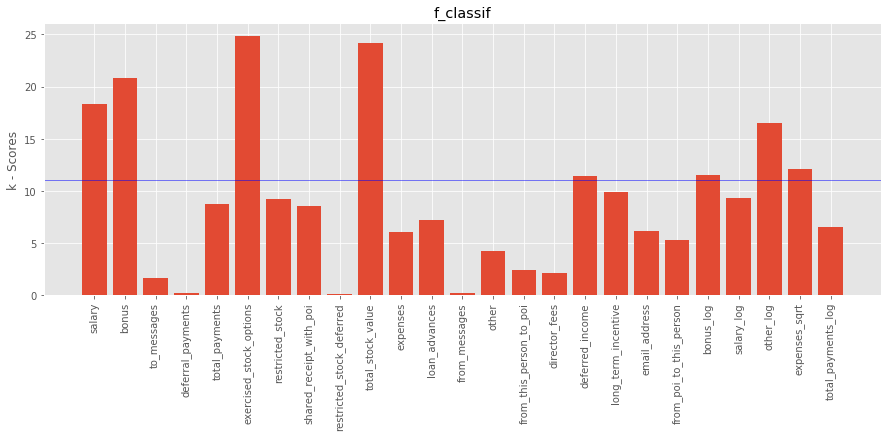

In [25]:
# Plotting and listing all the features based on k-scores

def get_k_scores(data_dict, features_list, score_func):
    """
    Returns a vector with feature scores.
    """

    from sklearn.feature_selection import SelectKBest
    import numpy as np
    
    # Parsing data_dict and splitting into features and labels
    data = featureFormat(data_dict, features_list)
    labels, features = targetFeatureSplit(data)
    
    # creating and fitting the selector using the features and labels
    k_best = SelectKBest(k='all',score_func = score_func)
    k_best.fit(features, labels)
    return k_best.scores_

# importing score functions
from sklearn.feature_selection import f_classif,mutual_info_classif

k_scores = get_k_scores(data_dict, all_features,f_classif)

fig=plt.figure(figsize=(15,5))
plt.bar(np.arange(len(k_scores)), k_scores, label = all_features[1:])
plt.ylabel('k - Scores')
plt.title('f_classif')
plt.xticks(np.arange(len(k_scores)),all_features[1:],rotation="vertical")
plt.axhline(y=11,color='b',linewidth=.5)
plt.show()


The top features (including new features) using `f_classif` based on k-scores are:
    
    0. salary 
    1. bonus 
    5. exercised_stock_options
    9. total_stock_value
    16. deferred_income
    20. bonus_log
    22. other_log
    23. expenses_sqrt

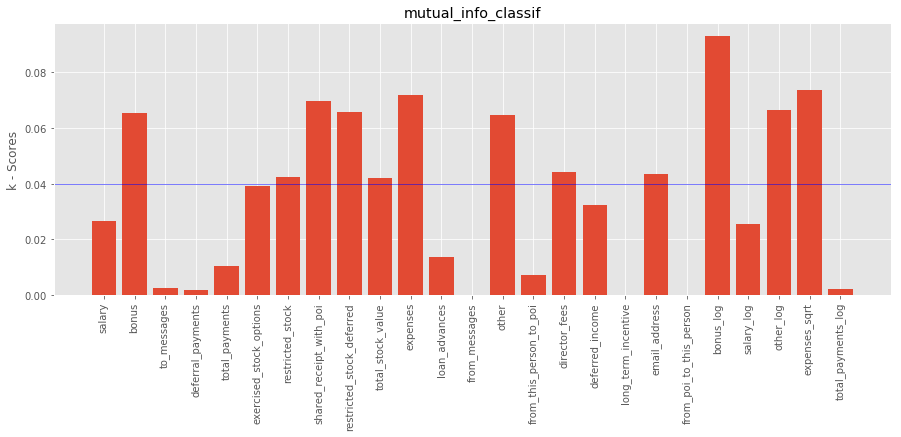

In [26]:
k_scores_m = get_k_scores(data_dict, all_features,mutual_info_classif)

fig=plt.figure(figsize=(15,5))
plt.bar(np.arange(len(k_scores_m)), k_scores_m)
plt.ylabel('k - Scores')
plt.title('mutual_info_classif')
plt.xticks(np.arange(len(k_scores_m)),all_features[1:],rotation="vertical")
plt.axhline(y=0.04,color='b',linewidth=.5)
plt.show()

The top features based on k-scores using `mutual_info_classif` are:
    
    1. bonus
    7. shared_receipt_with_poi
    9. total_stock_value
    10. expenses
    13. other
    20. bonus_log
    22. other_log
    23. expenses_sqrt

## PCA
Unlike univariate feature selector, `PCA` transform the data into principal components based on eigen values (importance).

* 99.9% of the variance can be explained using the top 6 principal components. Hence n_components = 6 for feature selection. Hence `n_components` has to be set from 1 to 6 to find the best model without overfitting.


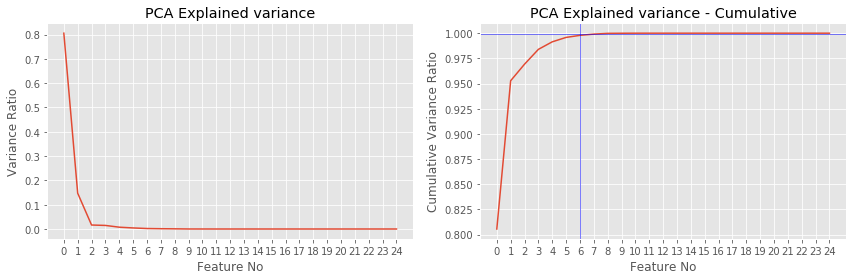

In [27]:
# component selction using pca. Task: To find the minimum number of components to explain variance in features.

from sklearn.decomposition import PCA
pca =PCA()
pca.fit(features,labels)

fig=plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(pca.explained_variance_ratio_)
plt.xticks(np.arange(N_FEATURES))
plt.xlabel('Feature No')
plt.ylabel('Variance Ratio')
plt.title('PCA Explained variance')
plt.subplot(122)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xticks(np.arange(N_FEATURES))
plt.axhline(y=.999,color='b',linewidth=.5)
plt.axvline(x=6,color='b',linewidth=.5)
plt.xlabel('Feature No')
plt.ylabel('Cumulative Variance Ratio')
plt.title('PCA Explained variance - Cumulative')
plt.tight_layout()
plt.show()

## Feature importances from Tree based classifier

Various decision trees like Random Forest and Extra Trees can be used to estimate the importance of features using `feature_importances_`.

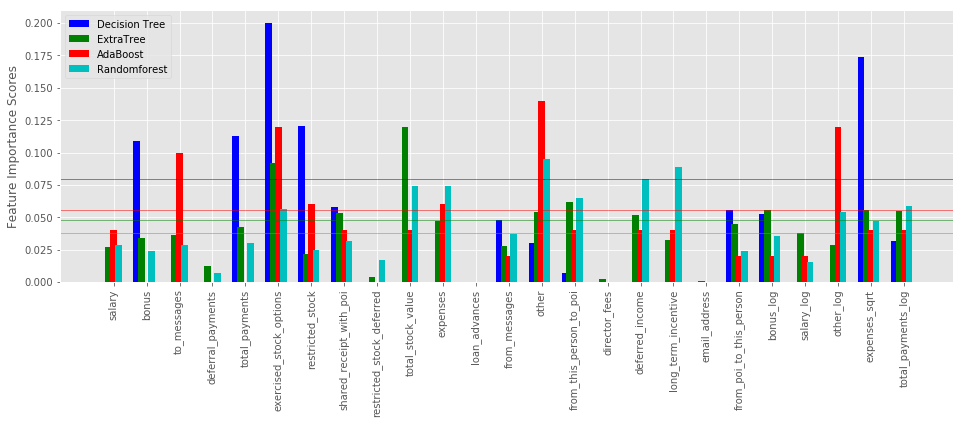

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier,AdaBoostClassifier,RandomForestClassifier

classifiers = [("Decision Tree",DecisionTreeClassifier()),\
               ("ExtraTree",ExtraTreesClassifier()),\
               ("AdaBoost",AdaBoostClassifier()),\
               ("Randomforest",RandomForestClassifier())]
COLORS = 'bgrcmyk'

width_bar =0.2
fig=plt.figure(figsize=(16,5))
for i, (name, clf) in enumerate(classifiers):
    clf.fit(features,labels)
    imp = clf.feature_importances_
    plt.bar(np.arange(N_FEATURES)+(0.75*width_bar)*(i),imp, \
            width=width_bar,color=COLORS[i], label = name)
    plt.axhline(y=0.4*np.amax(imp),color=COLORS[i],linewidth=0.5)
plt.xticks(np.arange(N_FEATURES)+0.3,all_features[1:],rotation="vertical")
plt.legend()
plt.ylabel("Feature Importance Scores")
plt.show()

## Recursive Feature Elimination (RFE)
Recursive feature elimination (RFE) provide a small set of features by recursively eliminating features using an external estimator. We found that using around 5 to 6 features give the best scores for various classifiers tested as indicated below.

In [163]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier,AdaBoostClassifier,\
            RandomForestClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

classifiers = [("Logistic",LogisticRegression()),\
                ("Decision Tree",DecisionTreeClassifier()),\
                ("ExtraTree",ExtraTreesClassifier()),\
                ("AdaBoost",AdaBoostClassifier()),\
                ("Randomforest",RandomForestClassifier()),\
#                 ("Bagging",BaggingClassifier()),\
                ("GradientBoosting",GradientBoostingClassifier())]

top_features = {}
for name, estimator in classifiers:
    rfe = RFE(estimator, 6, step=1)
    rfe.fit(features, labels)
#     rfe.ranking_
    top_features[name] = [feature for i, feature in enumerate(all_features[1:]) if rfe.support_[i]==True]
    print name,":",top_features[name]

Logistic : ['from_poi_to_this_person', 'bonus_log', 'salary_log', 'other_log', 'expenses_sqrt', 'total_payments_log']
Decision Tree : ['total_payments', 'exercised_stock_options', 'restricted_stock', 'shared_receipt_with_poi', 'bonus_log', 'expenses_sqrt']
ExtraTree : ['exercised_stock_options', 'total_stock_value', 'deferred_income', 'bonus_log', 'other_log', 'expenses_sqrt']
AdaBoost : ['exercised_stock_options', 'expenses', 'other', 'from_this_person_to_poi', 'salary_log', 'total_payments_log']
Randomforest : ['restricted_stock', 'shared_receipt_with_poi', 'total_stock_value', 'expenses', 'other', 'other_log']
GradientBoosting : ['exercised_stock_options', 'expenses', 'from_this_person_to_poi', 'deferred_income', 'other_log', 'expenses_sqrt']


* A crossvalidated `RFE` is implemented to find the top features by rank based on the cross-validated scores. `X-`-axis represents the no. of features selected for obtaining the corresponding cross validated score.

Feature Ranking	: [1 1 1 1 1 1 1 1 1 1 1 1 3 1 2 1 1 1 4 1 1 1 1 1 1]
Logistic : ['salary', 'bonus', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'other', 'director_fees', 'deferred_income', 'long_term_incentive', 'from_poi_to_this_person', 'bonus_log', 'salary_log', 'other_log', 'expenses_sqrt', 'total_payments_log'] 



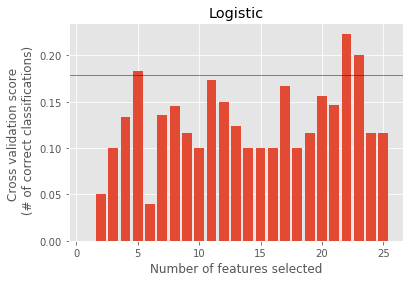

Feature Ranking	: [21 16 18 15  1  1  2  3 22 13 12 20  5 19  4 14 11 10  9  7  1  8  6  1 17]
Decision Tree : ['total_payments', 'exercised_stock_options', 'bonus_log', 'expenses_sqrt'] 



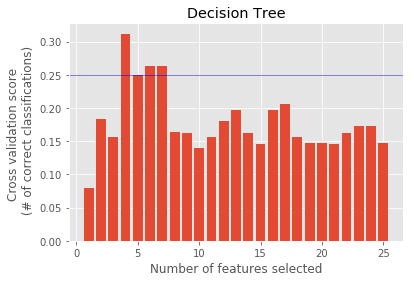

Feature Ranking	: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
ExtraTree : ['salary', 'bonus', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'other', 'from_this_person_to_poi', 'director_fees', 'deferred_income', 'long_term_incentive', 'email_address', 'from_poi_to_this_person', 'bonus_log', 'salary_log', 'other_log', 'expenses_sqrt', 'total_payments_log'] 



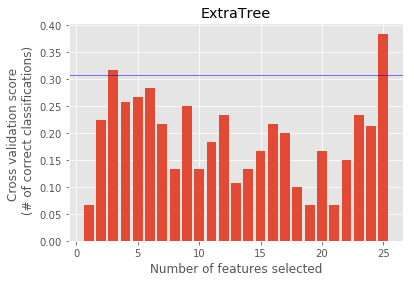

Feature Ranking	: [15 20 11 19  9  5  1 13 16 10  1 21 14  4  3 17  2  8 18 12  6  1  1  7 22]
AdaBoost : ['restricted_stock', 'expenses', 'salary_log', 'other_log'] 



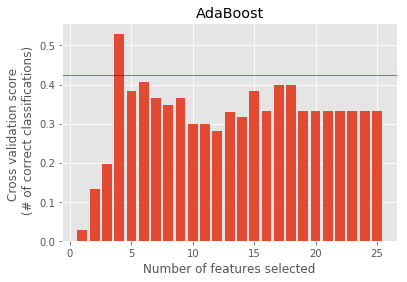

Feature Ranking	: [19  7 17 15 18  3 11  1 23  1  4 20 13  2 16 22  8  5 21 14 10 12  1  9  6]
Randomforest : ['shared_receipt_with_poi', 'total_stock_value', 'other_log'] 



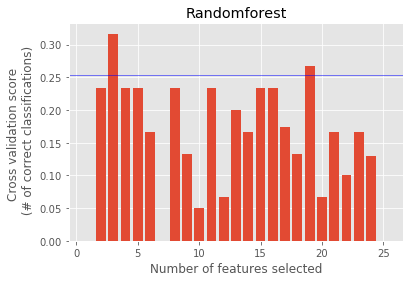

Feature Ranking	: [17 12 10 18 13  1  6  7 14  5  1 19  9  2  1 20  1 11 21 16  4 15  3  1  8]
GradientBoosting : ['exercised_stock_options', 'expenses', 'from_this_person_to_poi', 'deferred_income', 'expenses_sqrt'] 



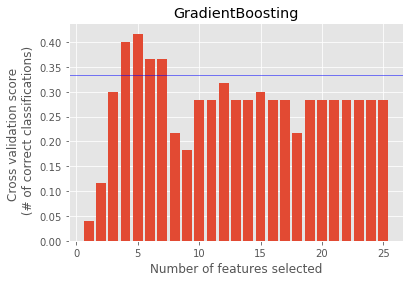

In [164]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier,\
    AdaBoostClassifier,RandomForestClassifier,\
    GradientBoostingClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.cross_validation import StratifiedKFold

# making a f2 scorer(weighted f1 score for precision and recall). beta =1 \
# recapture f1 score.
# value of beta<1 favour precision more
f2_scorer = make_scorer(fbeta_score, beta=1) 

#classifiers used to evaluvate
classifiers = [("Logistic",LogisticRegression()),\
                ("Decision Tree",DecisionTreeClassifier()),\
                ("ExtraTree",ExtraTreesClassifier()),\
                ("AdaBoost",AdaBoostClassifier()),\
                ("Randomforest",RandomForestClassifier()),\
#                 ("Bagging",BaggingClassifier()),\
                ("GradientBoosting",GradientBoostingClassifier())]

top_features = {}

for name, estimator in classifiers:
    rfecv = RFECV(estimator, step=1, cv=10,scoring=f2_scorer, verbose=0, n_jobs=-1)
    rfecv.fit(features, labels)
    print "Feature Ranking\t:",rfecv.ranking_
    top_features[name] = [feature for i, feature in enumerate(all_features[1:]) \
                          if rfecv.support_[i]==True]
    print name,":",top_features[name],"\n"
    
    # plot the scores
    plt.figure()
    plt.bar(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.title(name)
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score \n (# of correct classifications)")
    plt.axhline(y=0.8*np.amax(rfecv.grid_scores_),linewidth=0.5, color='b')
    plt.show()

## Optimal features and Choice of feature selector

For each classifier a different feature selection procedure was adopted. Each feature selector used in conjuction with classifier is cross-validated with `test_classifier`. and based on the highest scores, we chose the selector which has to be included in the final model.

Unlike univariate feature selectors such as `SlectKBest` and `RFE`, dimensionality reduction techniques like `PCA` create new combinations of attributes based all features available. In the case of decision tree classifier, the number of features can be controlled by adjusting the parameters.

### PCA + Logistic Regression
`PCA` with `n_components = 1` had the best performance when combined with Logistic Regression.
#### Features Selected : 
['salary', 'bonus', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'other', 'from_this_person_to_poi', 'director_fees', 'deferred_income', 'long_term_incentive', 'email_address', 'from_poi_to_this_person', 'bonus_log', 'salary_log', 'other_log', 'expenses_sqrt', 'total_payments_log']

### SelectKBest + Naive Bayes
`SelectKBEst` with `k = 8` had the highest performance for Naive Bayes.
#### Features Selected : 
['salary', 'bonus', 'exercised_stock_options', 'total_stock_value', 'deferred_income', 'bonus_log', 'other_log', 'expenses_sqrt']

### `feature_importances_` + Decision Tree

 The `feature_importances_` attribute of `DecisionTree` is used to select features.
 #### Features Selected : 
['exercised_stock_options', 'expenses','bonus_log', 'deferred_income', 'total_payments','from_this_person_to_poi', 'bonus', 'restricted_stock', 'salary','total_stock_value', 'email_address']

# Pick and Tune an Algorithm

1. What is tuning?
    * Tuning a classifier is to adjust the input parameters to obtain the best performance. The performance is often measured using the score of Accuracy, Precision, F1 score etc depending on the data as well as the model.

2. What is the main goal of tuning a classifier?

    * The main aim of tuning is to find the optimal value for the model or the highest predictability and generalize well to inseen data. For each classifier we have to find these parameters by adjusting and searching for the values.

3. Is there any possibility for us to over- or under-tune a classifier?

    * Yes, often there is a possibility to overtune and under tune a classifier
        * Overtuning classifier: Usually happens when too many features are used which will overfit data and fail to generalize to test data.
        * Undertuning classifier: Usually happens when there are too little features to train a classifier. This fails to capture the descision boundary properly.

4. What could go wrong if we tune a classifier aiming prediction scores on top of training data?

    * We have to test our model created using training with new test data so as to check whether the model generalize to new unseen data.

## Tuning Algorithm
Models are tunned using `tuning_[Model Name].py` and parameters are printed to a `.txt` file in the corresponding folder. `F1` score is used to evaluate the model since it allows optimizing both `Recall` and `Precision`. A ten fold crossvalidation is used in `GridsechCV` to pick the best tuning parameters, which will split data 10-fold to evaluate the scores for each fold.

** Algorithm and corresponding folders**
* Logistic Regression - /LR_Results
* Decision Tree - /DT_results
* Naive Bayes - /NB_results
* Adaboost - /ABD_results

Each folder contains `.txt` file with different parameters tested. the We use the average F1 score as the performance metric and the tunned parameters are used to create the final model for each algorithm as `tunned_[Model Name].py`. 



### Logistic Regression (LR)

Logistic Regression is implemented with top 3 performing models reported here. `LR_.txt` includes all the tested models. **LR_6** is selected as the best LR model since it uses only one transformed component of the PCA, and generalize well to test data without overfitting. The model **LR_6** can be produced by running `tunned_LR.py`.

 > Pipeline used to create the best LR model **LR_6**
 
 > **StandardScaler >>> PCA(n_components=1) >>> LogisticRegression**
 
 > All features are selected, and the first component of PCA is used.


----

**ID_	:	LR_6** [Selected]

new_features	:True

n_features	:25

Classifier	:
Pipeline(steps=[('StandardScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('classifLR', LogisticRegression(C=9.9999999999999995e-07, class_weight=None,random_state=None,
          solver='liblinear', tol=1e-06, verbose=0, warm_start=False))])

Selected Features	:
['salary', 'bonus', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'other', 'from_this_person_to_poi', 'director_fees', 'deferred_income', 'long_term_incentive', 'email_address', 'from_poi_to_this_person', 'bonus_log', 'salary_log', 'other_log', 'expenses_sqrt', 'total_payments_log']

accuracy	:0.766733333333
precision	:0.345750154353
recall		:0.84
f_1			:0.489867327599
f_2			:0.653238976592

-----

## Naive Bayes (NB)


Naive Bayes is implemented with top 2 models passing the required criteria are reported here. `NB_.txt` includes all the tested models. We take *Model-2* in the final Naive Bayes implementaion in `tunned_NB.py`.

Since Naive Bayes have not many parameters to tune, we control the number of features selected and check the scores.

 > Pipeline used to create the best NB model **Model-2**
 
 > **SelectKBest(k=8) >>> GaussianNB**
 
 > 8 features selected: ['salary', 'bonus', 'exercised_stock_options', 'total_stock_value', 'deferred_income', 'bonus_log', 'other_log', 'expenses_sqrt']


--- 
**Model - 1** [Selected]

new_features	:False

n_features	:20

Classifier	:
`Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selK', SelectKBest(k=13, score_func=<function f_classif at 0x109f9a9b0>)), ('classifNB', GaussianNB(priors=None))])`

Selected Features	:
['salary', 'bonus', 'total_payments', 'exercised_stock_options', 'restricted_stock', 'shared_receipt_with_poi', 'total_stock_value', 'expenses', 'loan_advances', 'deferred_income', 'long_term_incentive', 'email_address', 'from_poi_to_this_person']

accuracy	:0.781466666667
precision	:0.306948640483
recall		:0.508
f_1			:0.382674199623
f_2			:0.449160035367

--- 

## Decision Tree (DT)

Various Decision Tree models are tried and can be found in `DT_.txt`. The model implemented using DT is shown below.

 > Pipeline used to create the best DT model **Model-2**
 
 > **MinMaxScaler >>> DecisionTreeClassifier(max_depth=5)**
 
 > 11 features are used as shown in the tree diagram

---
**ID_	:	DT_18** [Selected]

Features used [('exercised_stock_options', 0.26311422700723708), ('expenses', 0.202422866059673), ('bonus_log', 0.14368552060296547), ('deferred_income', 0.11622047756050777), ('total_payments', 0.10459842980445701), ('from_this_person_to_poi', 0.074381105638724979), ('bonus', 0.029776132456896025), ('restricted_stock', 0.023416394401911515), ('salary', 0.020919685960891402), ('total_stock_value', 0.019271468279124231), ('email_address', 0.0021936922276114957)]
Pipeline(steps=[('MinMaxScaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('classifDT', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=True, random_state=42, splitter='best'))])
	Accuracy: 0.85373	Precision: 0.44387	Recall: 0.38350	F1: 0.41148	F2: 0.39422
	Total predictions: 15000	True positives:  767	Fal

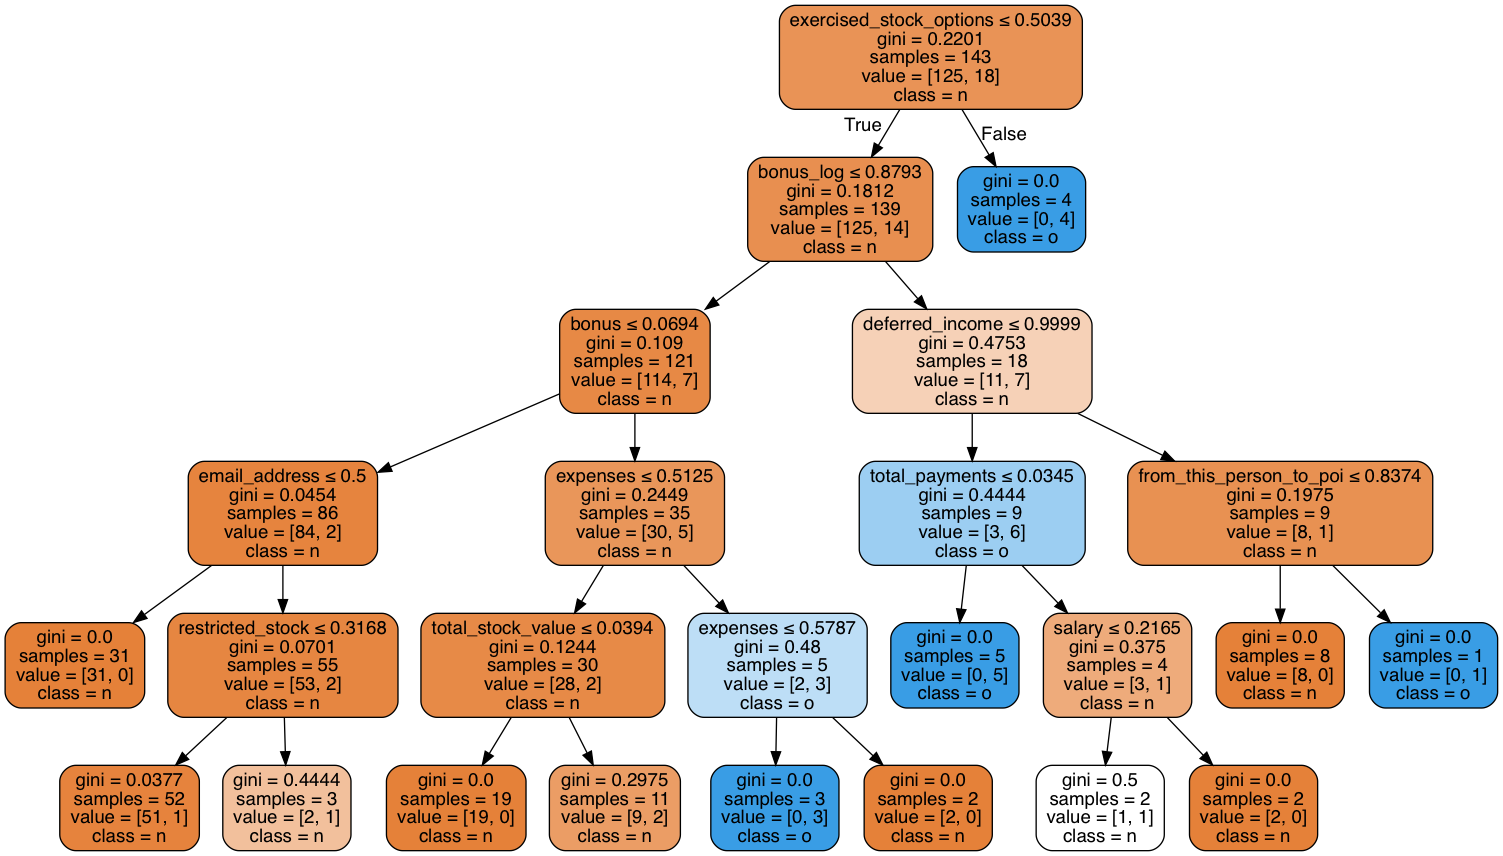

In [56]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from IPython.display import Image  
import pydotplus
from tester import test_classifier

features_list = ['poi',
				'salary','bonus','to_messages',
				'deferral_payments','total_payments','exercised_stock_options',
				'restricted_stock','shared_receipt_with_poi',
				'restricted_stock_deferred','total_stock_value',
				'expenses','loan_advances','from_messages','other',
				'from_this_person_to_poi','director_fees',
				'deferred_income','long_term_incentive',
				'email_address','from_poi_to_this_person']

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

### Task 2: Remove outliers
[data_dict.pop(key) for key in ["TOTAL","LOCKHART EUGENE E", "THE TRAVEL AGENCY IN THE PARK"]]

### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.
features_list, my_dataset = add_features(features_list, data_dict)
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

params = [{
    'classifDT__max_features':["sqrt","log2"],
    'classifDT__max_depth':np.arange(3,10)
}]

pipe = Pipeline(steps=[('MinMaxScaler', MinMaxScaler()), 
                       ('classifDT', DecisionTreeClassifier(random_state = 42, presort = True))])

DTree = GridSearchCV(estimator=pipe, param_grid=params, scoring='f1', n_jobs = -1, cv=10)
# fitting the classifier after Grid search
DTree.fit(features,labels)

unsorted = zip(features_list[1:],DTree.best_estimator_.named_steps['classifDT'].feature_importances_)
# max_no_features = DTree.best_estimator_.named_steps['classifDT'].n_outputs_
print "Features used",sorted(unsorted, key=lambda x: x[1], reverse=True)[0:11]

dot_data = export_graphviz(DTree.best_estimator_.named_steps['classifDT'], out_file=None,
                           feature_names=all_features[1:],class_names="non",filled=True, 
                           rounded=True,special_characters=True)

# Printing scores
accuracy, precision, recall, f1, f2 = test_classifier(DTree.best_estimator_, my_dataset, features_list)
print "\n\naccuracy\t:{0}\nprecision\t:{1}\nrecall\t\t:{2}\nf_1\t\t:{3}\nf_2\t\t:{4}\n".\
    format(accuracy, precision, recall, f1, f2)

# Visualizing the Decision Tree
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

## Pick an Algorithm

Pipeline used to create the best models for each algorithm

* **StandardScaler --> PCA(n_components=1) --> LogisticRegression**
  
* **SelectKBest(k=8) --> GaussianNB**
* **MinMaxScaler --> DecisionTreeClassifier(max_depth=5)**

We have chosen the best performing model in each algorithm implementation to draw a comparison. All three pass minimum requirements of the project i.e. `Precision >0.3 and Recall >0.3`. We chose Logistic Regression as the final Algorithm due to its simplicity with highest `f1 score`.

 ### Selected model
 
 > Pipeline used to create the best LogisticRegression [LR_6]
 
 > **StandardScaler >>> PCA(n_components=1) >>> LogisticRegression** 
 
 > All features are selected, and the first component of PCA is used.
 
 > **Selected Features : **['salary', 'bonus', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'other', 'from_this_person_to_poi', 'director_fees', 'deferred_income', 'long_term_incentive', 'email_address', 'from_poi_to_this_person', 'bonus_log', 'salary_log', 'other_log', 'expenses_sqrt', 'total_payments_log']

# Validate and Evaluate

> **Validation:** Model validation is referred to as the process where a trained model is evaluated with a testing data set. The testing data set is a separate portion of the same data set from which the training set is derived. The main purpose of using the testing data set is to test the **generalization** ability of a trained model. Model validation is carried out after model training. Together with model training, model validation aims to find an optimal model with the best performance based on the scores mentioned below
.

Here, validation of the classifier is done through the function `test_classifier` where data is split into train and test set using  `StratifiedShuffleSplit`. Since we have a class imbalance in our dataset, `StratifiedShuffleSplit` ensures that the test and train data contains equal proportions of classes. Using the function `test_classifier`, we perform  validation around  1000 fold and aggregate the results to report the performance metric.

The classifier is fitted with training set used to give predictions based on test data. We can define the various perfomance scores based on predicted value and true value as shown in the table below.

~|Predicted Value - 1|Predicted Value - 0
---:|:---:|:---:
**True Value - 1**|TP|FN
**True Value - 0**|FP|TN

>  Precision Score is when the algorithm guesses that somebody is a POI, this measures how certain we are that the person really is a POI.

$$ Precision = \frac{TP}{(TP+FP)}$$

>  Recall gives the fraction of POIs identified among all true POIs in the dataset.

$$Recall = \frac{TP}{(TP+FN)}$$

> Accuracy gives the fraction of POIs and non-POIs identified accurately by model in the total population.

$$Accuracy = \frac{TP+TN}{(TP+FP+TN+FN)}$$

> $F_1$ score is the harmonic average of precision and recall.

$$F_1 = 2 \cdot \frac{1}{\tfrac{1}{\mathrm{recall}} + \tfrac{1}{\mathrm{precision}}} = 2 \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{\mathrm{precision} + \mathrm{recall}}$$

> $F_\beta$ is the weighted harmonic average of precision and recall. $F_\beta$ weighs recall higher than precision where $\beta$ is the weight. Here we use $F_2$, where $\beta =2$

$$F_\beta = (1 + \beta^2) \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{(\beta^2 \cdot \mathrm{precision}) + \mathrm{recall}} = \frac {(1 + \beta^2) \cdot \mathrm{TP} }{(1 + \beta^2) \cdot \mathrm{TP} + \beta^2 \cdot \mathrm{FN} + \mathrm{FP}}$$


```python
def test_classifier(clf, dataset, feature_list, folds = 1000):
    data = featureFormat(dataset, feature_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    cv = StratifiedShuffleSplit(labels, folds, random_state = 42)
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
        
        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                print "Warning: Found a predicted label not == 0 or 1."
                print "All predictions should take value 0 or 1."
                print "Evaluating performance for processed predictions:"
                break
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        print clf
        print PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5)
        print RESULTS_FORMAT_STRING.format(total_predictions, true_positives, false_positives, false_negatives, true_negatives)
        print ""
    except:
        print "Got a divide by zero when trying out:", clf
        print "Precision or recall may be undefined due to a lack of true positive predicitons."
    return accuracy, precision, recall, f1, f2
    
    ```

## Evaluation

Evaluation of the models for each algorithm is based on the perfomance scores. We found that `Logistic_Regression` performs well in each scores evaluvated. 

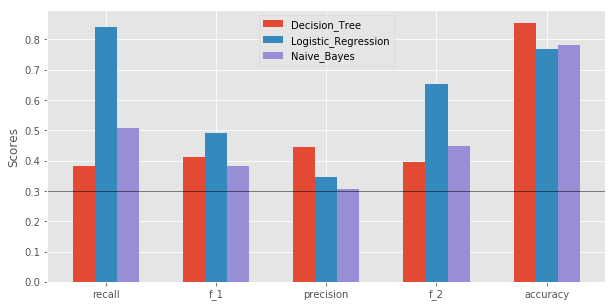

In [22]:
Algorithms = {
"Logistic_Regression":{
'accuracy'	:0.766733333333,
'precision'	:0.345750154353,
'recall'	:0.84,
'f_1'		:0.489867327599,
'f_2'		:0.653238976592},
"Naive_Bayes" : {
'accuracy'	:0.781466666667,
'precision'	:0.306948640483,
'recall'	:0.508,
'f_1'		:0.382674199623,
'f_2'		:0.449160035367},
"Decision_Tree" : {
'accuracy'	:0.853733333333,
'precision'	:0.443865740741,
'recall'	:0.3835,
'f_1'		:0.411480686695,
'f_2'		:0.394222861842}}

plt.figure(figsize=(10,5))
for j, A_name in enumerate(Algorithms):
    A_= Algorithms[A_name]
    plt.bar((np.arange(len(A_))+0.2*j)-0.2, A_.values(), align='center', width=0.2, label=A_name)
    plt.xticks(range(len(A_)), A_.keys())
plt.ylabel("Scores")
plt.axhline(y =0.3, color = "k", linewidth=0.5)
plt.legend()
plt.show()

# Conclusion

We have created a POI identifier based on Logistic Regression as shown above. We have also compared it with other algorithms namely Naive Bayes and Decision Tree. We found that each of these algorithms can be tunned to achieve higher metrics especially if we pick and choose the features with feature selection. In our final phase, we found that Logistic Regression gives the best metric for our data.

# References

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier
http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
http://scikit-learn.org/stable/auto_examples/plot_digits_pipe.html